# Cognitive Robotics and Computer Vision Assignment
### Using the 2017 COCO dataset from HuggingFace [rafaelpadilla/coco2017](https://huggingface.co/datasets/rafaelpadilla/coco2017)

In [134]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
from IPython.display import clear_output, display
import ipywidgets as widgets
from datasets import load_from_disk
import cv2

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope

# from datasets import load_dataset


In [172]:
# Import COCO dataset

# from datasets import load_dataset
#####################################
# # Full dataset (fetch from source)
# dataset = load_dataset("rafaelpadilla/coco2017")
# print(dataset)
# dataset.save_to_disk("coco2017.hf")
#####################################

# Read dataset
dataset = load_from_disk("coco2017.hf")

Loading dataset from disk:   0%|          | 0/39 [00:00<?, ?it/s]

Displaying a sample image with annotations:


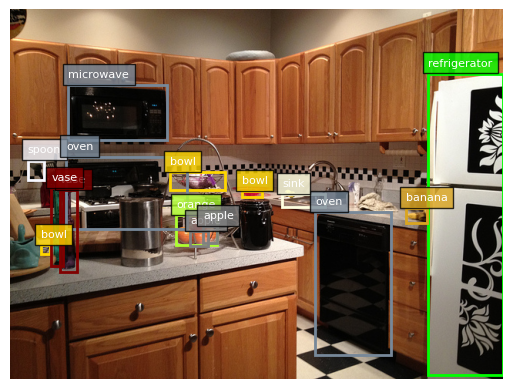

Label(value='refrigerator: 1')

Label(value='bowl: 3')

Label(value='banana: 1')

Label(value='orange: 1')

Label(value='microwave: 1')

Label(value='oven: 2')

Label(value='sink: 1')

Label(value='spoon: 1')

Label(value='vase: 2')

Label(value='apple: 2')

Button(button_style='success', description='Show a random img', style=ButtonStyle())

In [184]:
def show_sample(sample, annot=True):
    image = sample['image']
    plt.imshow(image)
    plt.axis('off') 

    labels = {}

    # Display annotations
    if 'objects' in sample and annot:
        objects = sample['objects']
        for i, obj in enumerate(objects['bbox']):
            label_index = objects['label'][i]
            label_text = label_names[label_index]
            if label_index in labels:
                labels[label_index]['count'] += 1
            else:
                labels[label_index] = {'count': 1, 'label': label_text}
            color = label_colors[label_text]
            rect = plt.Rectangle((obj[0], obj[1]), obj[2], obj[3],
                                 fill=False, edgecolor=color, linewidth=2)
            plt.gca().add_patch(rect)
            plt.gca().text(obj[0], obj[1] - 10, label_text,color='white', fontsize=8, bbox=dict(facecolor=color, alpha=0.8))
    
    plt.show()
    for l in labels.values():
        display(widgets.Label(f"{l['label']}: {str(l['count'])}"))

label_names = dataset['train'].features['objects'].feature['label'].names
# Generate a unique color for each label
colors = list(mcolors.CSS4_COLORS.values())
label_colors = {name: colors[i % len(colors)] for i, name in enumerate(label_names)}
length_of_train = len(dataset['train'])
random_index = random.randint(0, length_of_train - 1)

# Show a sample
print("Displaying a sample image with annotations:")
show_sample(dataset['train'][random_index])
len(label_names)

# Show a button to gen new image sample
def on_click(_callback):
    clear_output()
    random_index = random.randint(0, length_of_train - 1)
    print("Displaying a sample image with annotations:")
    show_sample(dataset['train'][random_index])
    display(button)

button = widgets.Button(description="Show a random img", button_style='success')
button.on_click(on_click)

# show the button
button

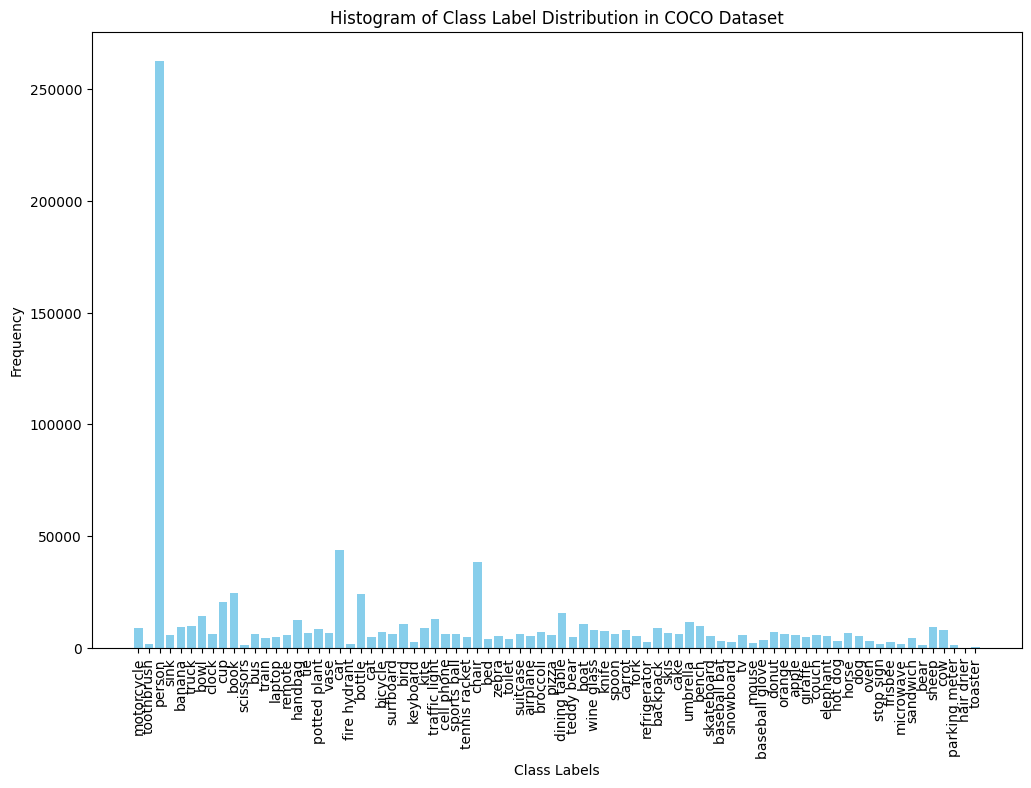

In [137]:
## EDA
instancesDict = {}
for instance in dataset['train']['objects']:
    for labelIndex in instance['label']:
        if labelIndex in instancesDict:
            instancesDict[labelIndex]['count'] += 1
        else:
            instancesDict[labelIndex] = {'count': 1, 'label': label_names[labelIndex]}



# plot histogram for all labels and their counts
labels = [instancesDict[key]['label'] for key in instancesDict]
classes =  np.array([key for key in instancesDict])
counts = [instancesDict[key]['count'] for key in instancesDict]

# Plotting the histogram
plt.figure(figsize=(12, 8))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Histogram of Class Label Distribution in COCO Dataset')
plt.xticks(rotation=90)
plt.show()

Need to fix the imbalance of the dataset by applying weights to each class

In [138]:

y_expanded = []
for label_idx, count in zip(classes, counts):
    y_expanded.extend([label_idx] * count)
y_expanded = np.array(y_expanded)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=classes, y=y_expanded)
class_weight_dict = {classes[i]: weight for i, weight in enumerate(class_weights)}

In [139]:
len(y_expanded)

860001

In [140]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Pre-process the data before by
-   Adding padding to images to avoid distortion on images whern resizing
-   Resize the images, will do 256x256
-   Normalize the images

In [186]:
def preprocess_image(x):
    import tensorflow as tf
    
    target_size=(224, 224)
    proc_img = []
    for i, image in enumerate(x['image']):
        try:
            # Convert image to tensor if necessary
            if not isinstance(image, tf.Tensor):
                image = tf.convert_to_tensor(image, dtype=tf.float32)

            # Ensure the image has 3 dimensions (height, width, channels)
            if len(image.shape) == 2:  # Grayscale maybe?
                image = tf.expand_dims(image, axis=-1)
                image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB by repeating the channel
            
            original_shape = tf.shape(image)[:2]

            # Get the shape of the image
            shape = tf.shape(image)
            height, width = shape[0], shape[1]

            # Calculate the padding sizes to make the image square
            delta = tf.abs(height - width)
            padding_small_side = delta // 2
            padding_large_side = delta - padding_small_side

            # Proper padding configuration for height, width, and channels
            if height > width:
                padding = [[0, 0], [padding_small_side, padding_large_side], [0, 0]]
            else:
                padding = [[padding_small_side, padding_large_side], [0, 0], [0, 0]]

            # Pad the image to make it square
            padded_image = tf.pad(image, padding, "CONSTANT")

            # Resize the image to the target size
            resized_image = tf.image.resize(padded_image, target_size)

            proc_img.append(resized_image)

            # Adjust bounding boxes
            for j, bbox in enumerate(x['objects'][i]['bbox']):
                bbox = tf.cast(bbox, dtype=tf.float64)

                # Calculate scale to preserve aspect ratio
                scale = min(target_size[0] / original_shape[0], target_size[1] / original_shape[1])
                new_height = tf.cast(original_shape[0], dtype=tf.float64) * scale
                new_width = tf.cast(original_shape[1], dtype=tf.float64) * scale

                # Calculate padding to center the image in the new size
                delta_height = target_size[0] - new_height
                delta_width = target_size[1] - new_width
                top, bottom = delta_height // 2, delta_height - (delta_height // 2)
                left, _ = delta_width // 2, delta_width - (delta_width // 2)

                # Adjust bounding box coordinates
                if height > width:
                    new_xmin = (bbox[0] + tf.cast(padding_small_side, dtype=tf.float64)) * scale + left
                    new_xmax = (bbox[2] + tf.cast(padding_small_side, dtype=tf.float64)) * scale + left
                    new_ymin = bbox[1] * scale - top + bottom
                    new_ymax = bbox[3] * scale - bottom
                else:
                    new_xmin = bbox[0] * scale + left
                    new_xmax = bbox[2] * scale + left
                    new_ymin = (bbox[1] + tf.cast(padding_small_side, dtype=tf.float64)) * scale - top + bottom
                    new_ymax = (bbox[3] + tf.cast(padding_small_side, dtype=tf.float64)) * scale  - bottom

                # Update the bounding box with new coordinates
                updated_bbox = [new_xmin.numpy(), new_ymin.numpy(), new_xmax.numpy(), new_ymax.numpy()]
                x['objects'][i]['bbox'][j] = updated_bbox


        except Exception as e:
            print(f"Error processing image: {e}")
            raise
    # Normalize the image before returning it
    return {'image': tf.divide(proc_img, 255.0), 'objects': x['objects']}

# Actuall usage (takes about an hour to run)
# dataset['train'] = dataset['train'].map(preprocess_image, num_proc=4, batch_size=128, batched=True)
# dataset.save_to_disk("coco2017_processed_train.hf")

# TEST CASE
# res = preprocess_image({'image': [dataset['train'][2342]['image']], 'objects': [dataset['train'][2342]['objects']]})
# print(dataset['train'][2342]['objects']['bbox'])
# print(res['objects']['bbox'])

# LOAD FROM SAVED
dataset = load_from_disk("coco2017_processed_train.hf")

Loading dataset from disk:   0%|          | 0/226 [00:00<?, ?it/s]

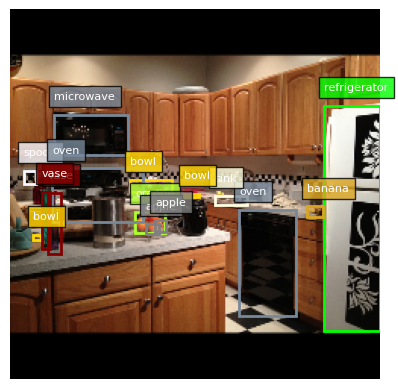

Label(value='refrigerator: 1')

Label(value='bowl: 3')

Label(value='banana: 1')

Label(value='orange: 1')

Label(value='microwave: 1')

Label(value='oven: 2')

Label(value='sink: 1')

Label(value='spoon: 1')

Label(value='vase: 2')

Label(value='apple: 2')

In [187]:
# print("Displaying a sample image with annotations:")
show_sample(dataset['train'][random_index])

In [143]:
# ## Fix 244 to 224
dataset['train'][random_index]['image'] = tf.image.resize(dataset['train'][random_index]['image'], (224, 224))

In [144]:
# show_sample(dataset['train'][random_index])

In [145]:
# # Shuffle the dataset
# shuffled_dataset = dataset.shuffle(seed=42)

# total = 2000
# l = widgets.FloatProgress(min=0, max=total)
# def preprocess_data(sample, itera, max_objects=80):
#     l.value = itera
#     image = sample['image']
#     bboxes = sample['objects']['bbox']  # All bounding boxes
#     labels = sample['objects']['label']  # All labels

#     # Prepare zero-initialized arrays for bounding boxes and labels
#     padded_bboxes = np.zeros((max_objects, 4))
#     padded_labels = np.zeros((max_objects,))

#     num_objects = len(bboxes)
#     if num_objects > 0:
#         padded_bboxes[:num_objects] = bboxes[:max_objects]  # Only take up to max_objects
#         padded_labels[:num_objects] = labels[:max_objects]
    
#     return image, padded_bboxes, padded_labels

# display(l)
# images, bboxes, labels = zip(*[preprocess_data(dataset['train'][i],i) for i in range(0, total)])

# images2 = np.array(images)
# bboxes2 = np.array(bboxes)
# labels2 = np.array(labels)

# # %store -r images2 bboxes2 labels2

In [148]:
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import ipywidgets as widgets
import matplotlib.pyplot as plt

# Assuming dataset is a placeholder for your actual dataset
# shuffled_dataset = dataset.shuffle(seed=42)
total = 1000
l = widgets.FloatProgress(min=0, max=total)
display(l)

def preprocess_data(sample, itera, max_objects=80):
    image = sample['image']
    bboxes = sample['objects']['bbox']  # All bounding boxes
    labels = sample['objects']['label']  # All labels

    # Prepare zero-initialized arrays for bounding boxes and labels
    padded_bboxes = np.zeros((max_objects, 4))
    padded_labels = np.zeros((max_objects,))

    num_objects = len(bboxes)
    if num_objects > 0:
        padded_bboxes[:num_objects] = bboxes[:max_objects] 
        padded_labels[:num_objects] = labels[:max_objects]
    
    return image, padded_bboxes, padded_labels

def update_progress(result):
    # Increment the progress bar value
    l.value += 1
    return result

def process_data_in_parallel():
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = [executor.submit(preprocess_data, dataset['train'][i], i) for i in range(total)]
        results = [update_progress(future.result()) for future in futures]
    return results

results = process_data_in_parallel()
images, bboxes, labels = zip(*results)

images2 = np.array(images)
bboxes2 = np.array(bboxes)
labels2 = np.array(labels)

FloatProgress(value=0.0, max=1000.0)

KeyboardInterrupt: 

In [ ]:
# %store images2 bboxes2 labels2
# %store -r images bboxes labels

Stored 'images2' (ndarray)
Stored 'bboxes2' (ndarray)
Stored 'labels2' (ndarray)


In [8]:
## Fix 244 to 224
images_rs = tf.image.resize(images2, (224, 224))

In [9]:

# move to when weights are calculated
# # Create a mapping from original class IDs to sequential class IDs starting from 0
# unique_classes = sorted(class_weight_dict.keys())
# class_mapping = {class_id: idx for idx, class_id in enumerate(unique_classes)}

# # Create a new class weights dictionary with sequential keys
# class_weight_dict = {class_mapping[class_id]: weight for class_id, weight in class_weight_dict.items()}
class_weights = np.array([class_weight_dict[k] for k in sorted(class_weight_dict.keys())])

def weighted_categorical_crossentropy(weights):
    
    weights = tf.constant(weights, dtype=tf.float32)
    
    def loss(y_true, y_pred):
        y_pred /= tf.reduce_sum(y_pred, axis=-1, keepdims=True)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        # calc the loss
        loss = y_true * tf.math.log(y_pred) * weights
        loss = -tf.reduce_sum(loss, -1)
        return loss
    
    return loss


In [190]:
print("Image data shape:", images_rs.shape)  # Expecting (num_samples, 224, 224, 3)
print("Bounding boxes shape:", bboxes2.shape)  # Expecting (num_samples, 4)
print("Labels shape:", labels2.shape)  # Expecting (num_samples, 80)

Image data shape: (2000, 224, 224, 3)
Bounding boxes shape: (2000, 80, 4)
Labels shape: (2000, 80)


In [189]:
def normalize_bounding_boxes(bboxes, image_width, image_height):
    normalized_bboxes = np.zeros_like(bboxes, dtype=np.float32)
    normalized_bboxes[..., 0] = bboxes[..., 0] / image_width   # x_min
    normalized_bboxes[..., 1] = bboxes[..., 1] / image_height  # y_min
    normalized_bboxes[..., 2] = bboxes[..., 2] / image_width   # x_max
    normalized_bboxes[..., 3] = bboxes[..., 3] / image_height  # y_max

    return normalized_bboxes

norm_bbox = normalize_bounding_boxes(bboxes2, 224, 224)

In [193]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')

# Load a pre-trained VGG16/MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# Output layers
# bbox_head = Dense(4, activation='sigmoid', name='bbox')(x)
bbox_head = Dense(80 * 4, activation='sigmoid')(x)  # 80 boxes, 4 coords each
bbox_head = Reshape((80, 4), name='bbox')(bbox_head)  # Reshape to (80, 4)
class_head = Dense(80, activation='softmax', name='class_output')(x)

# Complete model
model = Model(inputs=base_model.input, outputs=[bbox_head, class_head])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'bbox': 'mse', 'class_output': weighted_categorical_crossentropy(class_weights)},
              metrics={'bbox': 'mae', 'class_output': 'accuracy'})

model.summary()

# Fit the model
model.fit(x=images_rs, y={'bbox': norm_bbox, 'class_output': labels2},
          batch_size=32, epochs=50, callbacks=[tensorboard_callback])



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']      

1/1 [==============================] - 0s 354ms/step
person
[128.41928  142.38112   62.00294   12.366149]
airplane
[ 82.663826 101.65628   35.07912    2.378781]
car
[97.38626   83.68808   27.626299   2.2586086]


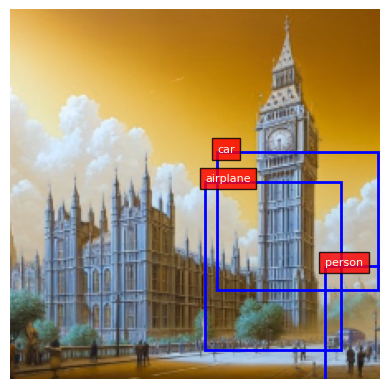

Label(value='person: 1')

Label(value='airplane: 1')

Label(value='car: 1')

In [215]:
# model.save('frcnn-2.h5')
# loss: 765.5110 - bbox_loss: 0.0044 - class_output_loss: 765.5067 - bbox_mae: 0.0186 - class_output_accuracy: 0.3240
# get metrics
# res = model.evaluate(x=images_rs, y={'bbox': norm_bbox, 'class_output': labels2})
# print(res)

path_of_new_image = 'bigben.jpg'

with custom_object_scope({'loss':{'bbox': 'mse', 'class_output': weighted_categorical_crossentropy(class_weights)}}):
    model = load_model('frcnn-2.h5')
    
def process_new_img(image, target_size=(224, 224)):
    # Convert image to tensor if necessary
    if not isinstance(image, tf.Tensor):
        image = tf.convert_to_tensor(image, dtype=tf.float32)

    # Ensure the image has 3 dimensions (height, width, channels)
    if len(image.shape) == 2:  # Grayscale maybe?
        image = tf.expand_dims(image, axis=-1)
        image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB by repeating the channel

    original_shape = tf.shape(image)[:2]

    # Get the shape of the image
    shape = tf.shape(image)
    height, width = shape[0], shape[1]

    # Calculate the padding sizes to make the image square
    delta = tf.abs(height - width)
    padding_small_side = delta // 2
    padding_large_side = delta - padding_small_side

    # Proper padding configuration for height, width, and channels
    if height > width:
        padding = [[0, 0], [padding_small_side, padding_large_side], [0, 0]]
    else:
        padding = [[padding_small_side, padding_large_side], [0, 0], [0, 0]]

    # Pad the image to make it square
    padded_image = tf.pad(image, padding, "CONSTANT")

    # Resize the image to the target size
    resized_image = tf.image.resize(padded_image, target_size)

    return np.array(tf.divide(resized_image, 255.0))

ni = cv2.imread(path_of_new_image)
# cv2.imshow('img_RCNN', ni)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# ni= dataset['train'][12]['image']
ni = tf.convert_to_tensor(ni, dtype=tf.float32)
proc_img_RCNN = process_new_img(ni)
# cv2.imshow('proc_img_RCNN', proc_img_RCNN)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
proc_img_RCNN2 = np.expand_dims(proc_img_RCNN, axis=0)
proc_img_RCNN2.shape
res = model.predict(proc_img_RCNN2)
idx = res[1][0][:].argsort()[-3:][::-1]

plt.imshow(proc_img_RCNN)
plt.axis('off') 

labels = {}

# Display annotations
for i, obj in enumerate(res[0][0][idx]):
    obj = obj * 224
    label_index = idx[i]
    label_text = label_names[label_index]
    print(label_text)
    if label_index in labels:
        labels[label_index]['count'] += 1
    else:
        labels[label_index] = {'count': 1, 'label': label_text}
    rect = plt.Rectangle((obj[0] + obj[2], obj[1] + obj[3]), obj[0], obj[1],
                         fill=False, edgecolor='b', linewidth=2)
    print(obj)
    plt.gca().add_patch(rect)
    plt.gca().text(obj[0] + obj[2], obj[1] + obj[3], label_text,color='white', fontsize=8, bbox=dict(facecolor='r', alpha=0.8))

plt.show()
for l in labels.values():
    display(widgets.Label(f"{l['label']}: {str(l['count'])}"))

## Trying with Traditional ML

In [151]:
%store -r images bboxes labels
test_images = images[:5]  # 5 images for demonstration
test_bboxes = bboxes[:5]
test_labels = labels[:5]

test_images[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [152]:
import cv2
import numpy as np

# Assuming `images` is your array of images and `bboxes` is the array of corresponding bounding boxes
# For example, let's say we load them from somewhere, but here we'll create dummy arrays for illustration:
# images = np.load('path_to_your_images.npy')  # Your 2000 images, 244x244 size, already loaded
# bboxes = np.load('path_to_your_bboxes.npy')  # Your bounding boxes

# Simulate data
test_images = images[:-1]
test_bboxes = bboxes[:-1]
test_labels = labels[:-1]

def convert_to_uint8(image):
    return (255 * image).astype(np.uint8)

images_uint8 = np.array([convert_to_uint8(img) for img in test_images])

In [153]:
###########################################

orb = cv2.ORB_create()
# Create BFMatcher object with crossCheck set to False for ratio test
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

def detect_and_describe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = orb.detectAndCompute(gray, None)
    return keypoints, descriptors
    
def match_features(desc1, desc2):
    # Find the two closest matches for each feature
    matches = bf.knnMatch(desc1, desc2, k=2)
    
    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    return good_matches

def draw_matches(img1, kp1, img2, kp2, matches):
    return cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


def validate_keypoints_in_bbox(kp, bboxes, labels):
    labels_count = {}
    for i, bbox in enumerate(bboxes):
        x, y, w, h = bbox
        label = label_names[int(labels[i])]
        if label not in labels_count:
            labels_count[label] = 0
        # Check if keypoint is inside the bounding box
        if x <= kp.pt[0] <= x + w and y <= kp.pt[1] <= y + h:
            labels_count[label] += 1
    return labels_count

def get_most_frequent_label(labels_count):
    print(labels_count)
    return max(labels_count, key=labels_count.get) if labels_count else None

def best_match(img_dataset, new_desc, new_kp, new_image):
    # Assuming `images` is a list of images loaded into memory
    best_match_idx = -1
    max_good_matches = 0

    # Iterate over all images in the dataset to find the best match
    for idx, img in enumerate(img_dataset):
        kp, desc = detect_and_describe(img)
        good_matches = match_features(new_desc, desc)

        # Update best match if current image has more good matches
        if len(good_matches) > max_good_matches:
            max_good_matches = len(good_matches)
            best_match_idx = idx

    # Output the best matching image
    if best_match_idx != -1:
        best_matching_image = images_uint8[best_match_idx]
        cv2.imshow('Best Matching Image', best_matching_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        print(f"Best match found in image index: {best_match_idx} with {max_good_matches} good matches AS: {test_labels[best_match_idx]}")
        # show draw matches
        cv2.imshow('Draw Matches', draw_matches(new_image, new_kp, best_matching_image, kp, good_matches))
        # show the label
        cv2.imshow('Label', test_labels[best_match_idx])
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("No good matches found in the dataset")


In [216]:
def get_best_match(ni):
    # Load the new image
    new_image = convert_to_uint8(ni[0])
    new_kp, new_desc = detect_and_describe(new_image)

    # match_features(new_desc, dataset_desc)
    # best_match(images_uint8, new_image, new_kp, new_desc)
    # Detect and describe features for the new image

    # Variables to store the best match info
    best_match_idx = -1
    max_good_matches = 0
    best_labels = None
    good_matches = None

    # Compare new image against each dataset image
    for idx, (img, bboxes) in enumerate(zip(images_uint8, test_bboxes)):
        kp_dataset, desc_dataset = detect_and_describe(img)
        good_matches = match_features(new_desc, desc_dataset)

        dataset_labels_count = {}
        for match in good_matches:
            dataset_kp = kp_dataset[match.trainIdx]
            labels_count = validate_keypoints_in_bbox(dataset_kp, bboxes, test_labels[idx])
            for label, count in labels_count.items():
                if label not in dataset_labels_count:
                    dataset_labels_count[label] = 0
                dataset_labels_count[label] += count

        if len(good_matches) > max_good_matches:
            max_good_matches = len(good_matches)
            best_match_idx = idx
            best_labels = get_most_frequent_label(dataset_labels_count)

    print(f"Best match found in image index: {best_match_idx} with {max_good_matches} good matches. Most frequent labels: {best_labels}")
    img_selected = images_uint8[best_match_idx]
    kp_dataset, desc_dataset = detect_and_describe(img_selected)
    good_matches = match_features(new_desc, desc_dataset)
    cv2.imshow('Draw Matches', draw_matches(new_image, new_kp, img_selected, kp_dataset, good_matches))
    cv2.waitKey(0)
    cv2.destroyAllWindows()



In [220]:
img_index = 323

ni, nbb, nl = zip(preprocess_data(dataset['train'][img_index], img_index))

ni = np.array(ni)

ni = np.array(convert_to_uint8(ni))

# show_sample(dataset['train'][img_index])

ni = cv2.imread('random.jpg')
ni = np.array(tf.divide(tf.convert_to_tensor([ni], dtype=tf.float32), 255.0))
get_best_match(ni)

{'motorcycle': 6, 'None': 0}
{'pizza': 9, 'None': 0}
{'airplane': 11, 'person': 0, 'truck': 0, 'None': 0}
{'couch': 0, 'chair': 0, 'person': 0, 'book': 0, 'laptop': 0, 'None': 0}
Best match found in image index: 837 with 15 good matches. Most frequent labels: couch
